In [1]:
import pandas as pd
import segysak
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.interpolate import NearestNDInterpolator

In [2]:
from devito import *
from examples.seismic import SeismicModel, plot_velocity, demo_model
from examples.seismic.source import RickerSource, Receiver, TimeAxis

In [3]:
#Закоменти, чтобы выполнять на CPU
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [4]:
def plot_hist_pars(el_pars, ignore_zero=False):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3), dpi=150)
    
    for (k, v), ax in zip(el_pars.items(), axs):
        data = v.data.to_numpy().flatten()
        if ignore_zero:
            data = data[data != 0]
        ax.set_title(k)
        ax.hist(data, bins=20)
        ax.set_ylim([0, 20])
    plt.show()

In [5]:
def CreateSeismicModel(vp,vs,rho, origin, spacing, shape, so, nbl, bcs='damp'):

    model = demo_model(preset='layers-elastic', nlayers=3, shape=shape, spacing=spacing,
                   space_order=so, origin = origin, nbl = nbl)

    rho_data_nozero = np.where(rho == 0, 1, rho)
    
    model.update('vp', vp)
    model.update('vs', vs)
    model.update('b', 1/rho_data_nozero)

    model._initialize_physics(vp=vp,
                              vs=vs,
                              b=model.b.data[nbl:-nbl, nbl:-nbl],
                              space_order=so
                             )
    return model

In [6]:
def nn_interp_coords(data: np.ndarray, origin: tuple, domain_size : tuple, spacing : tuple, dim_vectors : tuple):
    value = data.flatten()
    x, z = np.meshgrid(*dim_vectors)
    X, Z = [np.arange(o, ds+sp, step=sp, dtype='float') for o, ds, sp in zip(origin, domain_size, spacing)]
    Z, X = np.meshgrid(Z, X)
    interp = NearestNDInterpolator(list(zip( x.reshape(-1), z.reshape(-1))),value)
    new_value = interp(X, Z)

    return new_value

In [7]:
sc_path = '2D_Scenarios'
scenarios = glob.glob(sc_path+r'/sc*')
scenarios

['2D_Scenarios/sc_2', '2D_Scenarios/sc_1']

Эту модель будут варьировать на предмет наличия талых зон, поэтому будет несколько сценариев, для каждого сценария своя моделька

Ниже датафрейм с координатами приборов. Это и приемники, и источники одновременно, т.е. всего будет 319 сейсмограмм по 319 трасс

In [8]:
df_ins = pd.read_csv(sc_path+'/instruments.txt', sep='\t')
df_ins['Z'] += 2
df_ins['X'] = np.linspace(0,7950, 319)
df_ins

,X,Surf_idx,Z
0,0.0,26,52.0
1,25.0,26,52.0
2,50.0,27,54.0
3,75.0,27,54.0
4,100.0,27,54.0
...,...,...,...
314,7850.0,34,68.0
315,7875.0,34,68.0
316,7900.0,34,68.0
317,7925.0,34,68.0


In [9]:
constraints = {"Vp": 1800, "Vs": 750, "Rho" : 1500}

В изначальных моделях есть корявые ячейки у самой поверхности, где Vp очень низкие, контраст с соседними ячейками достигает 2000+. Когда волновой процесс доходит до этих ячеек, очень часто вылезает вычислительная неустойчивость. Не хочется ради них задирать порядок аппроксимации и улучшать дискретизацию<br>
Код ниже позволяет убрать их

In [10]:
for i, scenario in enumerate(scenarios[1:]): #single check
# for i, scenario in enumerate(scenarios): #whole
    readsgy = lambda x : xr.open_dataset(x,
                                         dim_byte_fields={"cdp" : 1},
                                         extra_byte_fields={'cdp_x':181, 'cdp_y':185}
                                        )
    el_pars = {file.split('/')[-1].split(' ')[0] : readsgy(file) for file in glob.glob(scenario+'/*.sgy')}
    # plot_hist_pars(el_pars, ignore_zero=True) # гистограммы параметров перед корректировкой
    for k, v in el_pars.items():
        el_pars[k] = el_pars[k].where(((el_pars[k] > constraints[k]) | (el_pars[k].samples>100) | (el_pars[k] == 0)), constraints[k])
    # plot_hist_pars(el_pars, ignore_zero=True)  # гистограммы параметров после корректировки

    # привычный формат
    rho_data = (el_pars["Rho"].data/1000).to_numpy()
    vp_data = (el_pars["Vp"].data/1000).to_numpy()
    vs_data = (el_pars["Vs"].data/1000).to_numpy()

    # сетка
    
    
    # инт данные
    

    # модель
    
    # оператор

    # выгрузка в sgy

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

In [11]:
dim_vectors = ((el_pars['Rho'].cdp.data-1)*25, (el_pars['Rho'].samples.data))
spacing = (1, 1) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
origin = (0, 0)
nbl = 20
so = 8

In [12]:
rho_data_int = nn_interp_coords(rho_data.T, origin, (7950, 1000), spacing, dim_vectors)
vp_data_int = nn_interp_coords(vp_data.T, origin, (7950, 1000), spacing, dim_vectors)
vs_data_int = nn_interp_coords(vs_data.T, origin, (7950, 1000), spacing, dim_vectors)

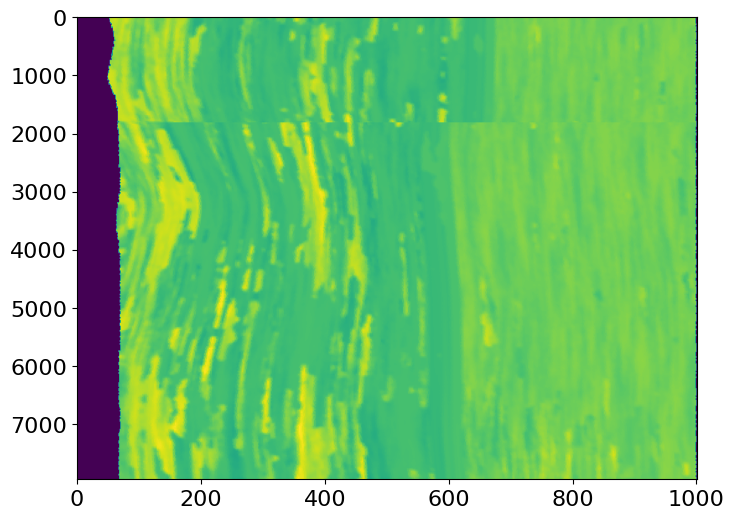

In [13]:
plt.imshow(vp_data_int, aspect='auto')

In [14]:
model = CreateSeismicModel(origin=origin,
                           spacing=spacing,
                           shape=vp_data_int.shape,
                           vp=vp_data_int,
                           vs=vs_data_int,
                           rho=rho_data_int,
                           so=so,
                           nbl=nbl,
                           bcs='damp'
                          )

Operator `initdamp` ran in 0.07 s


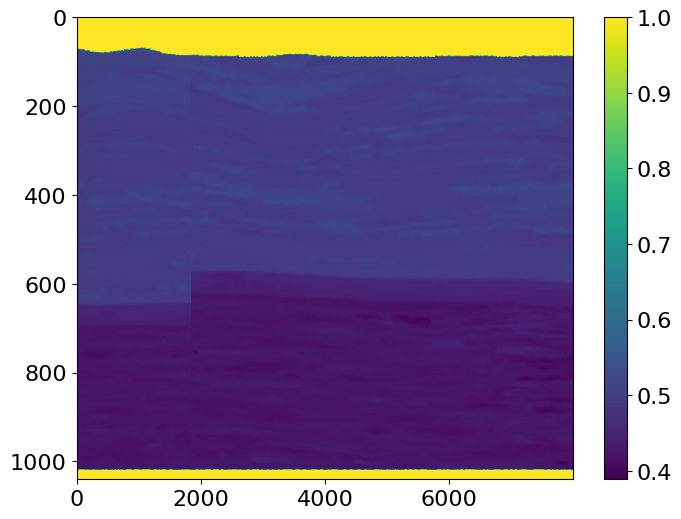

In [15]:
plt.imshow(model.b.data.T, aspect='auto')
plt.colorbar()

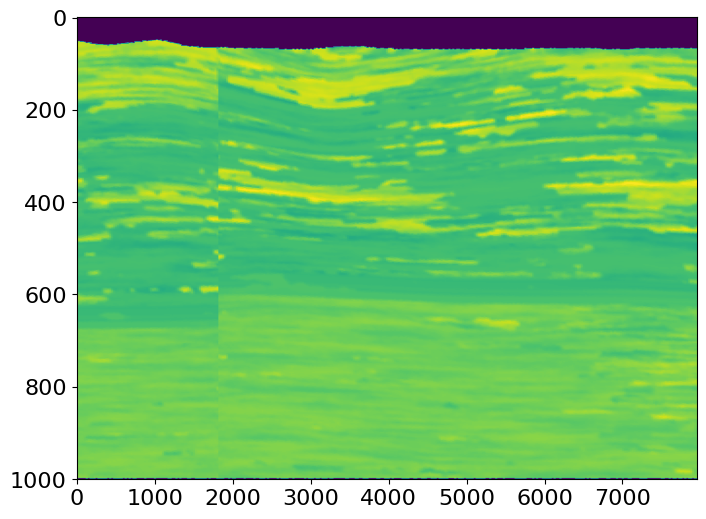

In [16]:
plt.imshow(vp_data_int.T,aspect='auto')

In [17]:
# def interp_coords(data: np.ndarray, dshape: tuple):
#     new_dims = []
#     for original_length, new_length in zip(data.shape, dshape):
#         new_dims.append(np.linspace(0, original_length-1, new_length))
#     coords = np.meshgrid(*new_dims, indexing='ij')
#     return (map_coordinates(data, coords, mode= 'nearest', order = 1))

In [18]:
model.critical_dt

np.float32(0.1673)

In [19]:
t0, tn = 0., 2000.
dt = model.critical_dt 
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid = model.grid, f0=0.05, time_range=time_range)
src.coordinates.data[:] = [df_ins['X'][159], df_ins['Z'][159]]

In [20]:
#create velocity and pressure fields
s = model.grid.time_dim.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=2)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=2)

In [22]:
# The source injection term
# src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
# src_zz = src.inject(field=tau.forward[1, 1], expr=s*src)
src_zz = src.inject(field=v.forward[1], expr=s*src)


# The receiver
nrec = df_ins.shape[0]

rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:,0] = df_ins['X']
rec.coordinates.data[:,1] = df_ins['Z']+2

rec_term = rec.interpolate(expr=v[1])
# rec_term = rec.interpolate(expr=tau[0,0] + tau[1,1])

In [23]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# First order elastic wave equation
pde_v = v.dt - ro * div(tau)
pde_tau = tau.dt - l * diag(div(v.forward)) - mu * (grad(v.forward) + grad(v.forward).transpose(inner=False))
# Time update
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
u_t = Eq(tau.forward,  model.damp * solve(pde_tau, tau.forward))

op = Operator([u_v] + [u_t] +
              # src_xx + 
              src_zz + 
              rec_term, platform='nvidiaX')

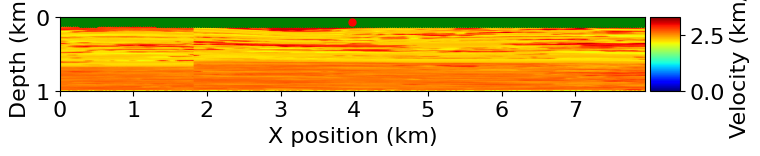

In [24]:
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data)

In [25]:
vp_data_int.shape

(7951, 1001)

(np.float64(1.0), np.float64(0.0))

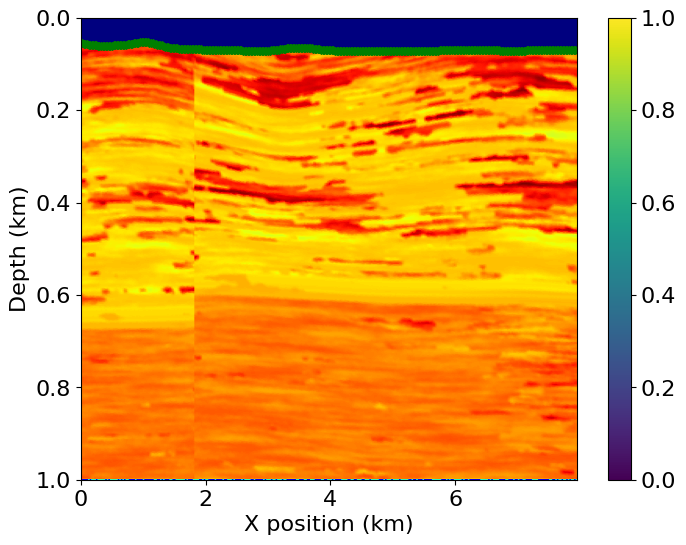

In [26]:
cmap = "jet"
scale = 1
vscale = 10
domain_size = 1.e-3 * np.array(model.domain_size)
extent = [model.origin[0], model.origin[0] + domain_size[0],
          model.origin[1] + domain_size[1], model.origin[1]]

slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
if getattr(model, 'vp', None) is not None:
    field = model.vp.data[slices]
else:
    field = (model.vp.data[slices])
plot = plt.imshow(np.transpose(field), animated=True, cmap=cmap,
                  vmin=np.min(field), vmax=np.max(field),
                  extent=extent, aspect='auto')

plt.xlabel('X position (km)')
plt.ylabel('Depth (km)')

plt.scatter(1e-3*rec.coordinates.data[:, 0], 1e-3*rec.coordinates.data[:, 1],
                    s=15, c='green', marker='D')
plt.colorbar()
plt.xlim()
plt.ylim()

In [27]:
op(dt=dt) 

Operator `Kernel` ran in 28.45 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=27.95075499999992, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.25626300000000884, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.11269899999997994, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [28]:
rec_max = rec.data.max(axis=0)
rec_max[rec_max == 0] = 1
rec_trace_norm = rec.data / rec_max

In [29]:
scale_for_plot = np.diag(np.linspace(1.0, 2.5, rec.data.shape[0])**2.0)

In [30]:
rec.data.shape

(11956, 319)

Text(0.5, 0, 'Receiver position (m)')

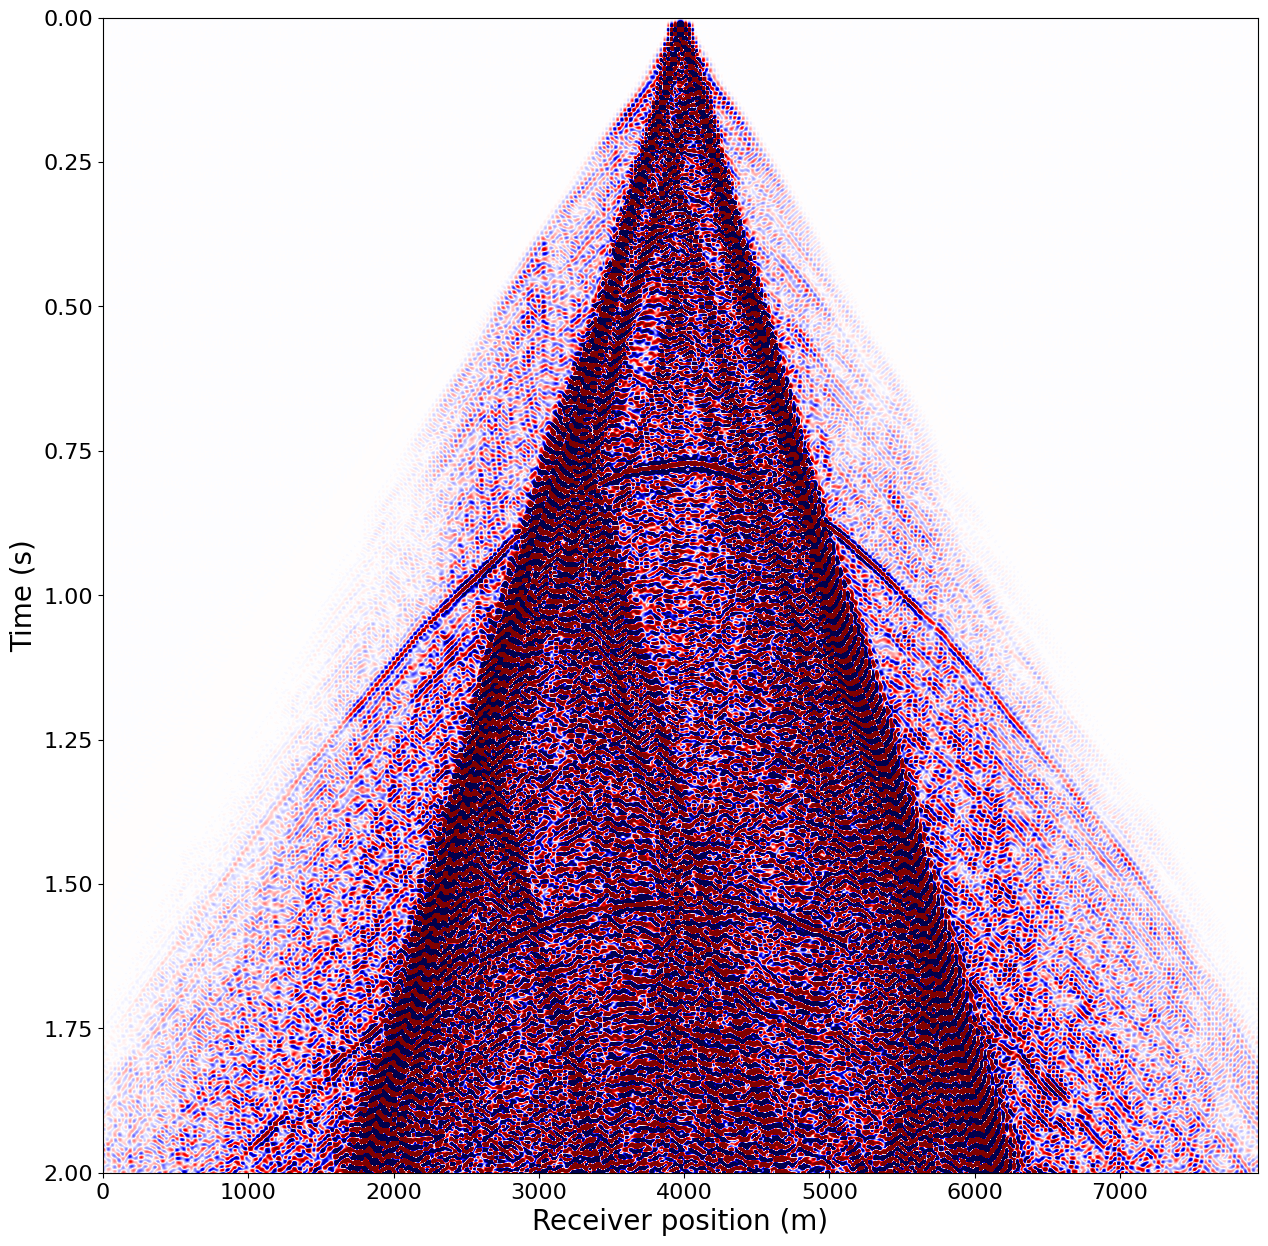

In [31]:
#NBVAL_SKIP
# Pressure (txx + tzz) data at sea surface
extent = [rec.coordinates.data[0, 0], rec.coordinates.data[-1, 0], 1e-3*tn, t0]
aspect = rec.coordinates.data[-1, 0]/(1e-3*tn)

plt.figure(figsize=(15, 15))
plt.imshow(np.dot(scale_for_plot, rec.data)[::10,:], vmin=-0.001, vmax=0.001, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)